# Study beam impact point as a function of beam position


In [1]:
%load_ext autoreload
%autoreload 

In [2]:
import timeit
import copy
import concurrent.futures 
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import batoid
from scipy import stats

from ghosts import tools
from ghosts import plotter
from ghosts import simulator
from ghosts import tweak_optics
from ghosts import beam
from ghosts import geom
from ghosts import reflectivity

from ghosts.analysis import compute_ghost_separations, reduce_ghosts
from ghosts.analysis import match_ghosts, compute_reduced_distance, compute_2d_reduced_distance, find_nearest_ghost
from ghosts.analysis import make_data_frame

from ghosts.beam_configs import BEAM_CONFIG_0, BEAM_CONFIG_1, BEAM_CONFIG_3, FAST_BEAM_CONFIG_1, BASE_BEAM_SET
from ghosts.geom_configs import GEOM_CONFIG_0, GEOM_CONFIG_1, GEOM_CONFIG_2

from ghosts.camera import build_camera, show_camera

plt.rcParams['font.size']=16

In [3]:
# Some numbers from the constants module for reference
from ghosts.constants import *
print(f'LSST Camera has {LSST_CAMERA_PIXEL_DENSITY_MM2:.0f} pixels per mm^2')
print(f'Camera readout noise {LSST_CAMERA_READOUT_NOISE:d} electrons')
print(f'Camera dark current {LSST_CAMERA_DARK_CURRENT:d} electrons')
print(f'Camera noise {LSST_CAMERA_NOISE:d} electrons')
print(f'Camera pixel size {LSST_CAMERA_PIXEL_SIZE:.6f} m')

LSST Camera has 9000 pixels per mm^2
Camera readout noise 5 electrons
Camera dark current 2 electrons
Camera noise 10 electrons
Camera pixel size 0.000010 m


## Straight forward computation of the expected number of photons per pixel expected in the main spot

In [4]:
# A few numbers, sepcific to 600 nm
beam_power_600nm = 13  # 13 Watt for the full spot according to measurements done in Grenoble
ccd_reflectivity_600nm = 0.141338
ccd_qe_600nm = 0.843274
lens_reflectivity_600nm = 0.004  # 0.4% code by Julien Bolmont
filter_reflectivity_600nm = 0.038  # r band filter documentation stated transmission is 96.2%

In [5]:
# Straight forward calculation for the main spot for 100 nW
n_phot = beam.get_n_phot_for_power_nw_wl_nm(100, 600)
print(f"N photons from 100 nW at 600 nm {n_phot:e}")
n_phot_to_pixel = n_phot * (1-lens_reflectivity_600nm)**6 \
                         * (1-ccd_reflectivity_600nm) \
                         * ccd_qe_600nm * 0.9  # lens transmission, detector transmission, QE and pixels fill
print(f"N photons to pixel {n_phot_to_pixel:e}")
spot_size = (1.25)**2*math.pi
print(f"Spot size in mm2 {spot_size:.1f}")
pixel_size = 10e-3**2
print(f"Pixel size in mm2 {pixel_size:.6f}")
n_pixel_spot = spot_size/pixel_size
print(f"N pixels per spot {n_pixel_spot:e}")
n_phot_per_pixel = n_phot_to_pixel/n_pixel_spot
print(f"N photons per pixel {n_phot_per_pixel:e} for 100 nW at 600 nm")

N photons from 100 nW at 600 nm 3.020470e+11
N photons to pixel 1.921605e+11
Spot size in mm2 4.9
Pixel size in mm2 0.000100
N pixels per spot 4.908739e+04
N photons per pixel 3.914661e+06 for 100 nW at 600 nm


## Now run the full CCOB simulation and analysis

In [6]:
# adjust beam config
BEAM_CONFIG_600 = copy.deepcopy(BEAM_CONFIG_3)
BEAM_CONFIG_600['id'] = 600
BEAM_CONFIG_600['wl'] = 600e-9
BEAM_CONFIG_600['n_photons'] = 1000


Direct path is number 10
  central impact point is (0.129987, 0.184197)
  transmission is 0.8383

Maximum expected flux is 0.8383
Maximum bin content is 601.0318


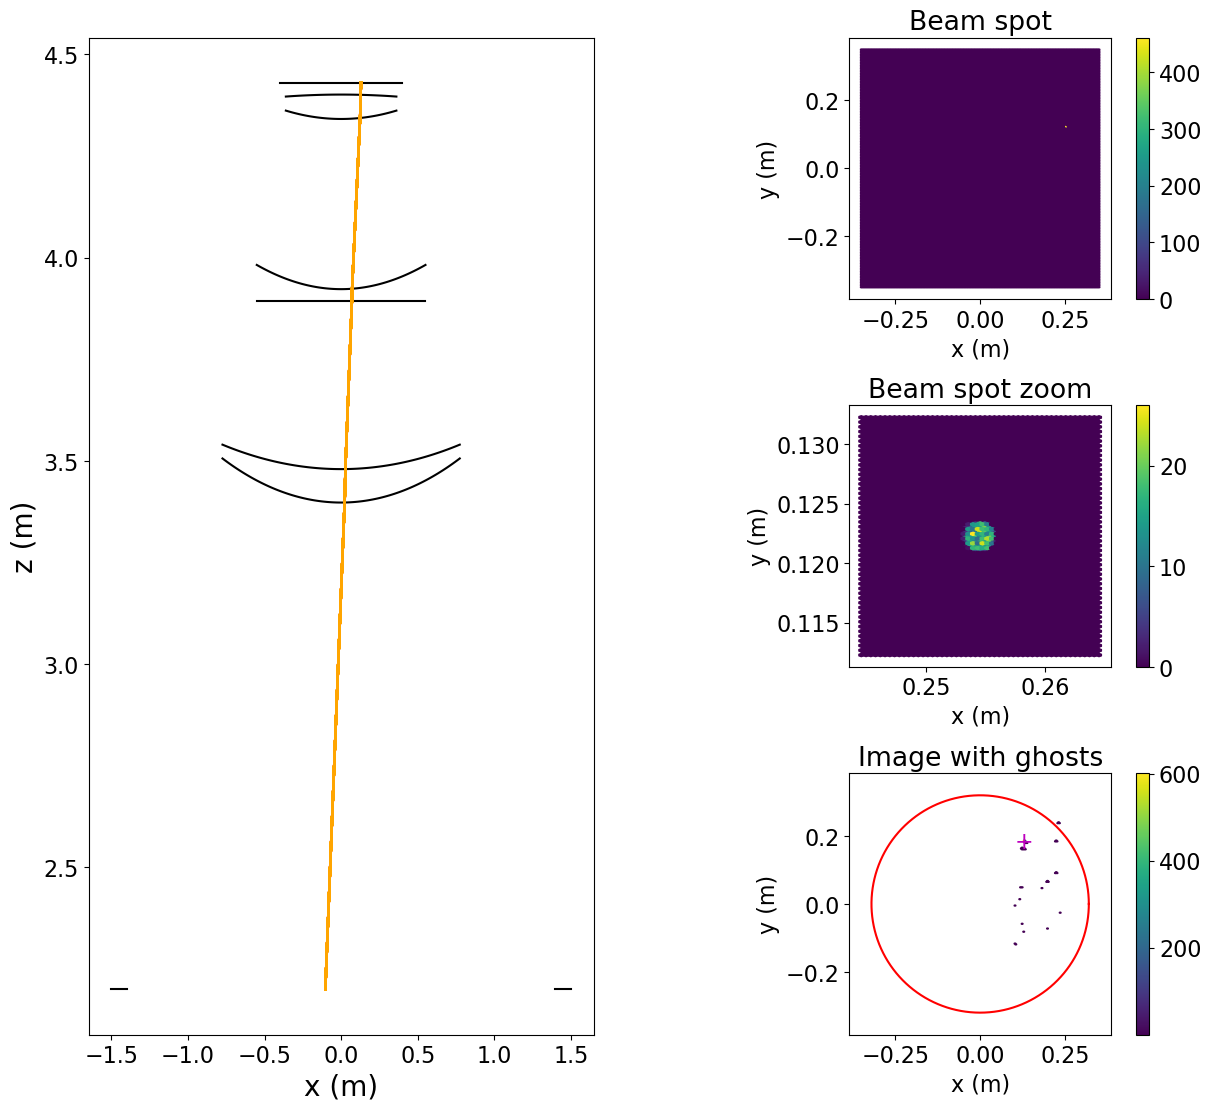

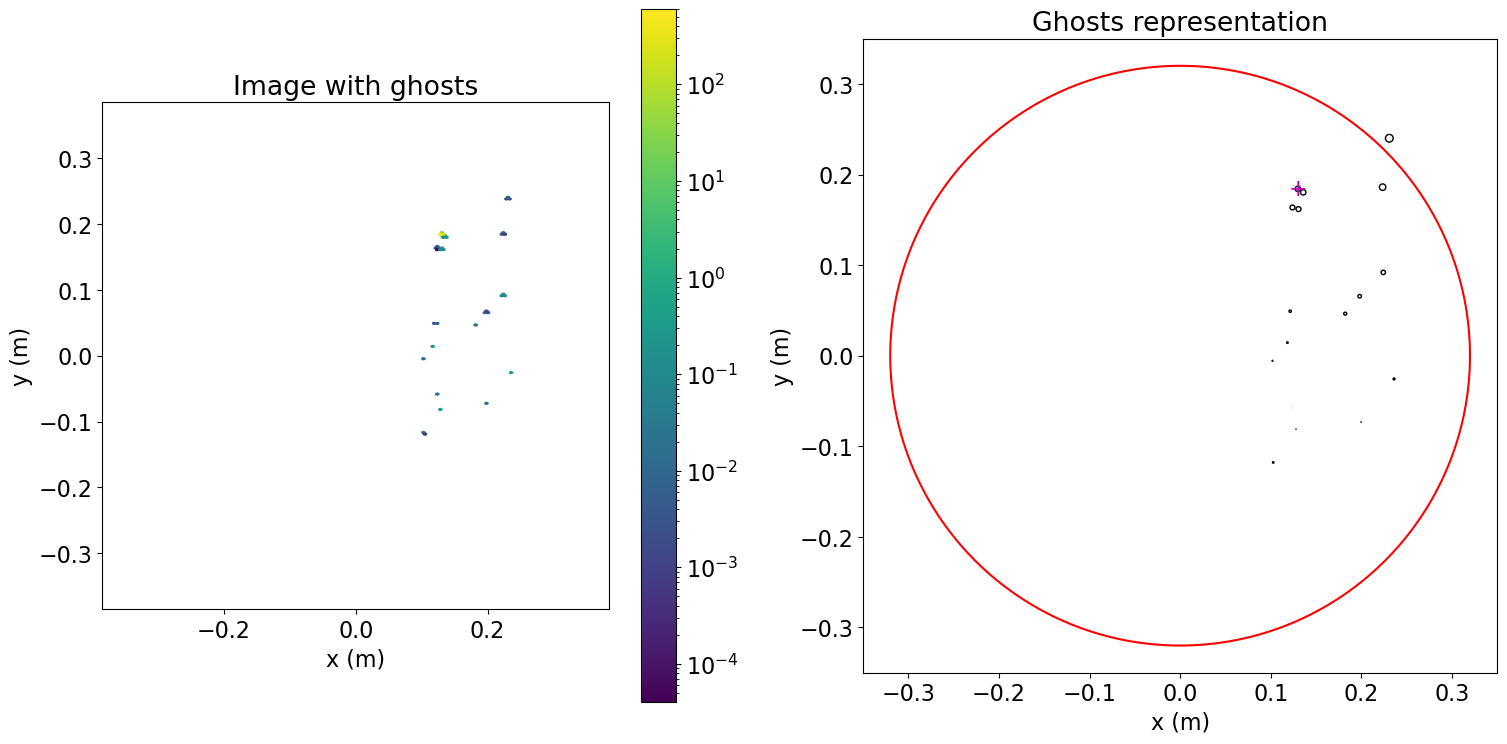

In [7]:
# Second CCOB like geometry, i.e. lenses + filters
telescope = batoid.Optic.fromYaml("../data/LSST_CCOB_r.yaml")

# Make refractive interfaces partially reflective
# Call on current telescope, smart coating is [lens, filter, camera]
tweak_optics.make_optics_reflective(telescope, coating='smart',
                                    r_frac=[lens_reflectivity_600nm, filter_reflectivity_600nm, ccd_reflectivity_600nm])

# Run simulation with standard beam config
trace_full, r_forward, r_reverse, rays = simulator.run_simulation(telescope, beam_config=BEAM_CONFIG_600)
simulation = [trace_full, r_forward, r_reverse, rays]
# Check setup
plotter.plot_setup(telescope, simulation)

# camera and ghosts visualization
spots_data, _spots = reduce_ghosts(r_forward)
spots_data_frame = make_data_frame(spots_data)
_fig, _ax = plotter.plot_full_camera_and_spots(r_forward, spots_data_frame, log_scale=True)

Ghosts map for 100 nW beam at 500 nm with a diameter of 2.5 mm


/home/bregeon/Rubin/CCOB/ghosts/ghosts/plotter.py:251: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  plt.tight_layout()


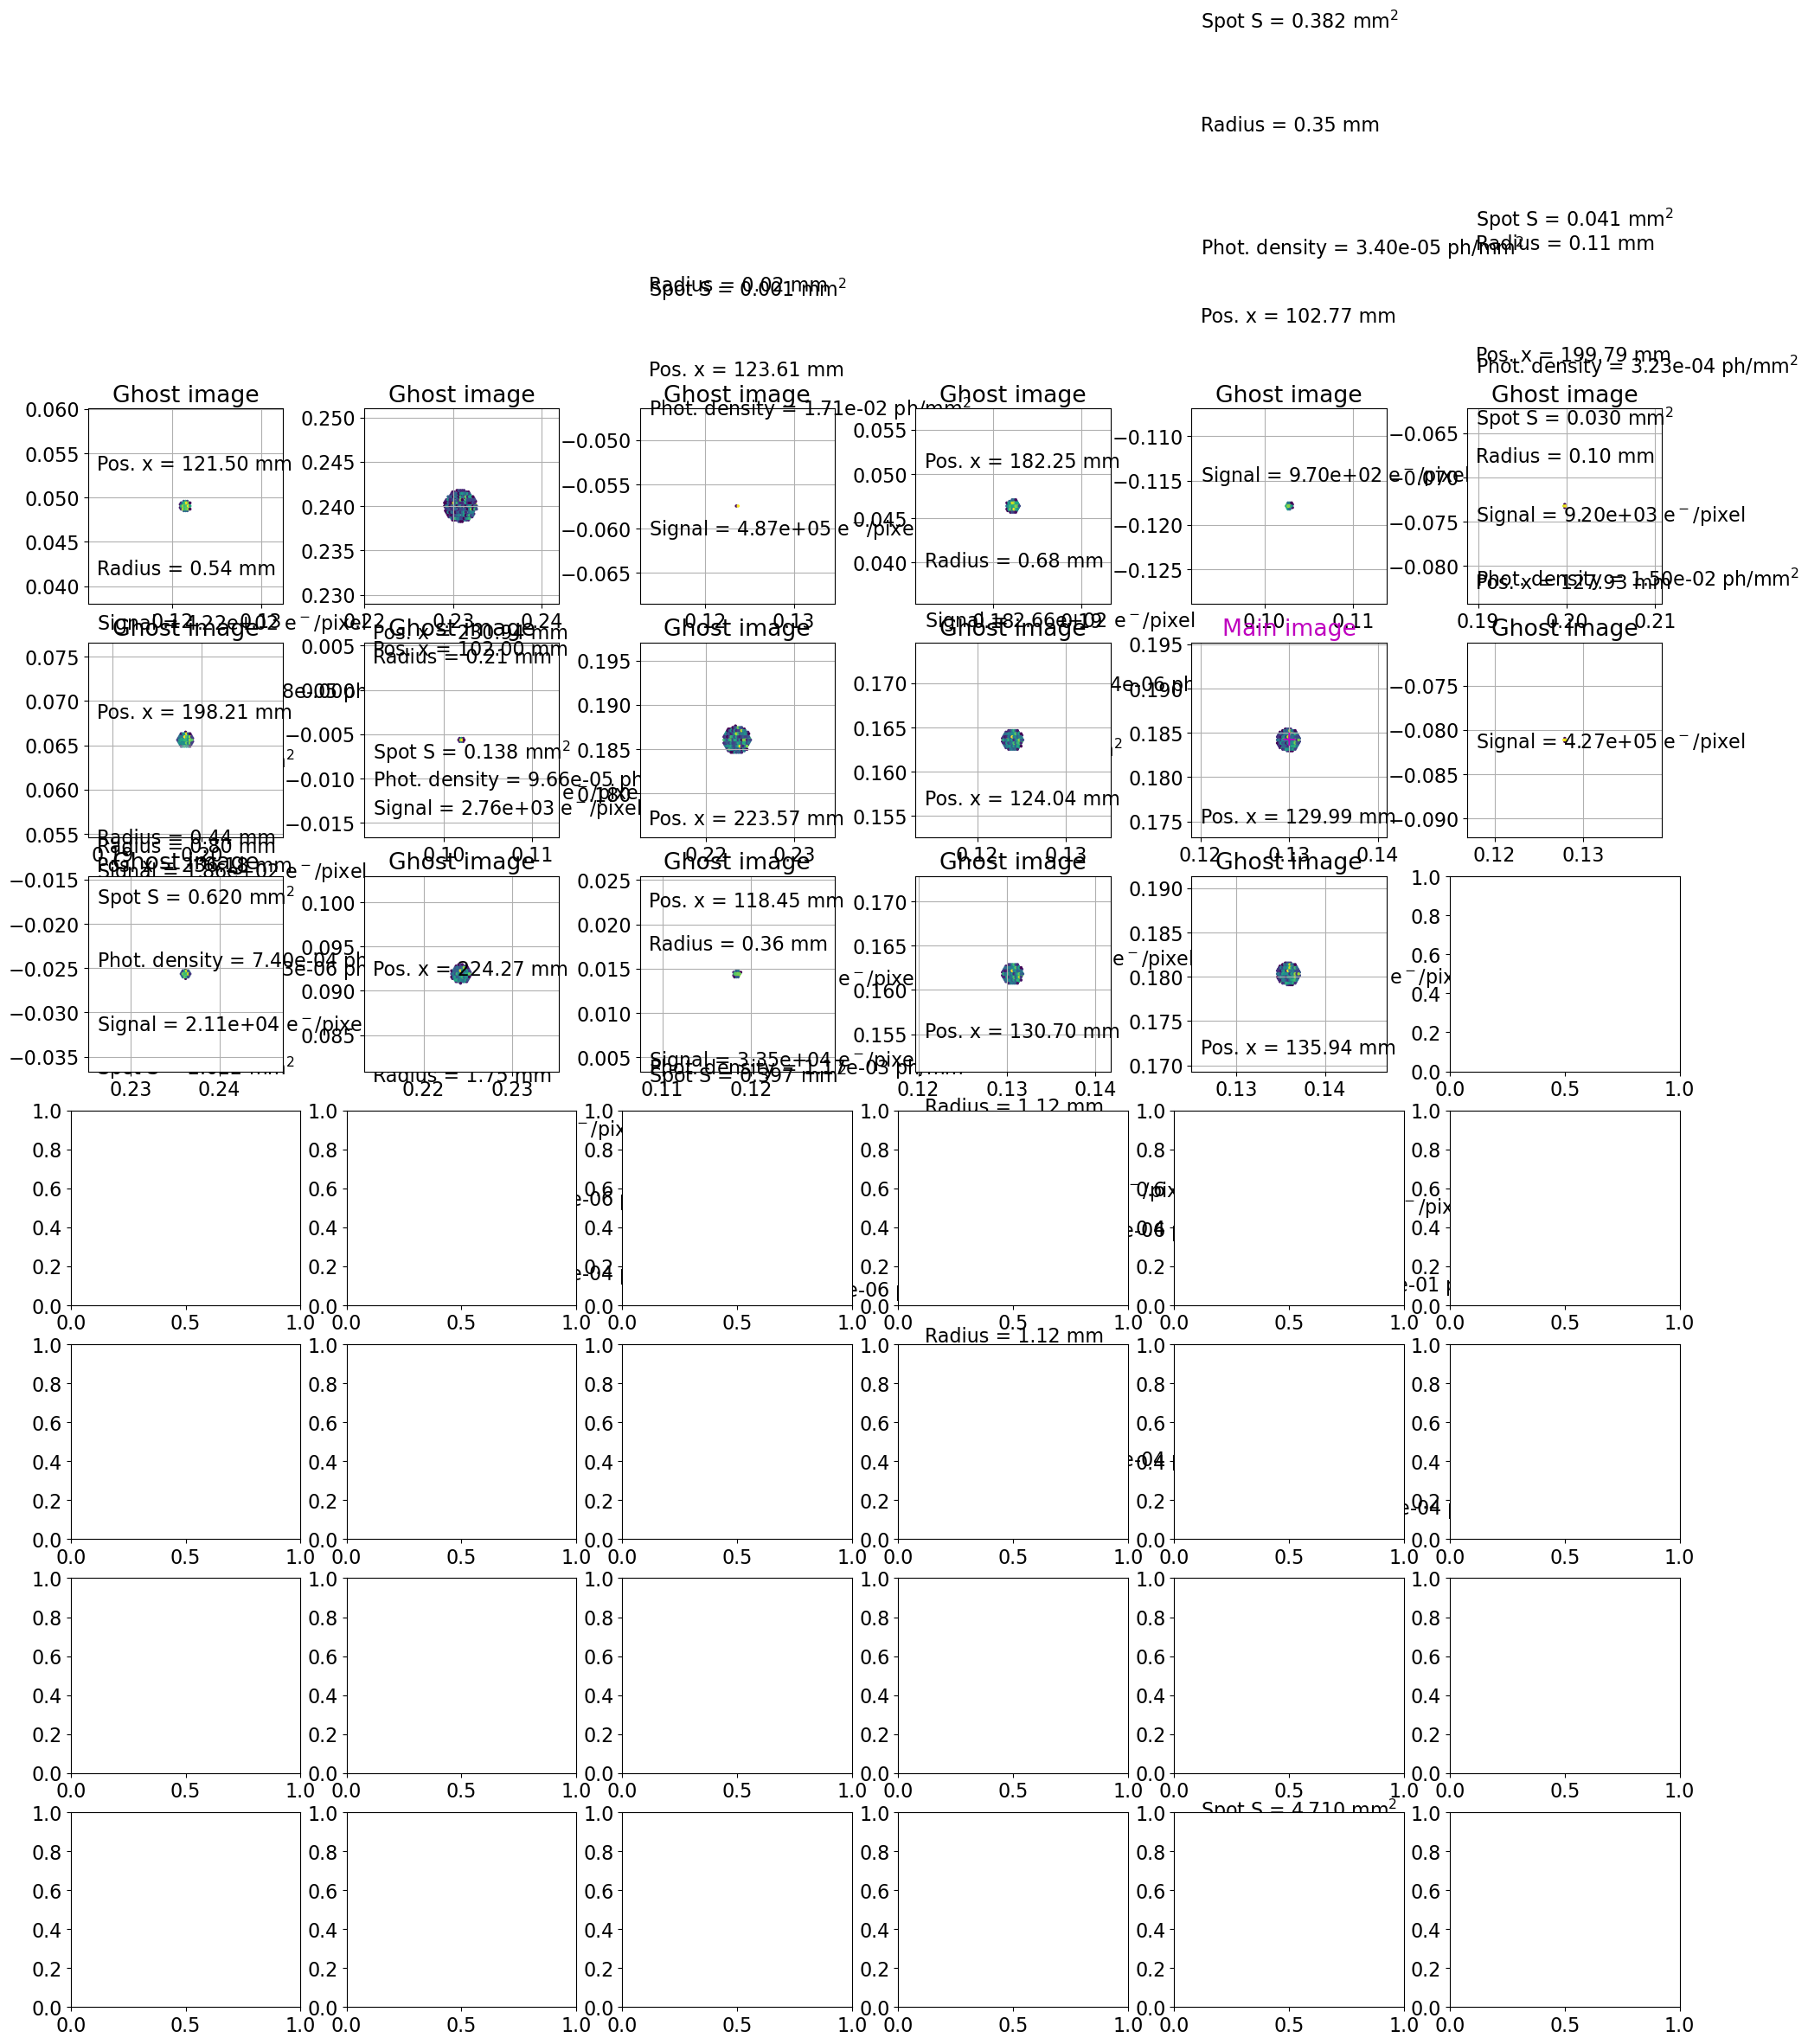

In [8]:
# make figure and fill with plots
plt.rcParams["figure.figsize"] = [24, 24]
spots_data = plotter.plot_ghosts_map(r_forward)

In [9]:
spots_data_frame.sort_values('pixel_signal', axis=0)

,beam_id,geom_id,index,name,pos_x,std_x,pos_y,std_y,width_x,width_y,radius,radius_err,flux,surface,n_pixels,pixel_signal
1,0,0,1,"(L2_exit, L1_entrance)",0.230939,0.000887,0.240013,0.000887,0.003519,0.003489,0.001752,1.479351e-05,0.013199,9.643707,86793.0,3.904294e+01
8,0,0,8,"(L3_entrance, L2_exit)",0.223566,0.000746,0.186041,0.000746,0.002958,0.002943,0.001475,7.353544e-06,0.013412,6.836146,61525.0,5.596775e+01
9,0,0,9,"(L3_exit, L3_entrance)",0.124044,0.000562,0.163596,0.000562,0.002229,0.002238,0.001117,4.563164e-06,0.013412,3.918830,35269.0,9.763214e+01
6,0,0,6,"(L3_exit, L2_entrance)",0.198212,0.000410,0.065606,0.000410,0.001624,0.001585,0.000802,1.995936e-05,0.013199,2.021936,18197.0,1.862169e+02
3,0,0,3,"(L2_entrance, L1_exit)",0.182253,0.000338,0.046395,0.000338,0.001342,0.001363,0.000676,1.068575e-05,0.013412,1.436559,12929.0,2.663335e+02
0,0,0,0,"(L1_exit, L1_entrance)",0.121495,0.000270,0.049041,0.000270,0.001070,0.001079,0.000537,4.169505e-06,0.013412,0.906531,8159.0,4.220527e+02
4,0,0,4,"(L3_exit, L1_entrance)",0.102766,0.000168,-0.117860,0.000168,0.000664,0.000731,0.000349,3.313541e-05,0.012989,0.382078,3439.0,9.697762e+02
7,0,0,7,"(L3_exit, L2_exit)",0.101999,0.000113,-0.005634,0.000113,0.000450,0.000388,0.000209,3.107287e-05,0.013305,0.137694,1239.0,2.756460e+03
16,0,0,16,"(Detector, L3_exit)",0.135943,0.000621,0.180324,0.000621,0.002462,0.002436,0.001224,1.259956e-05,0.473911,4.710276,42392.0,2.870132e+03
15,0,0,15,"(Detector, L3_entrance)",0.130699,0.000567,0.161818,0.000567,0.002247,0.002247,0.001123,2.500740e-07,0.470128,3.965256,35687.0,3.382171e+03


In [10]:
# scaling flux
main_flux = 4.983946e+06
target_flux = main_flux/100.
print(f"Main flux / 100 = {target_flux:e}, fair enough for 75000 full well")

Main flux / 100 = 4.983946e+04, fair enough for 75000 full well


In [11]:
round(6.9)

7